# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [304]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from copy import deepcopy
import pandas as pd

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [305]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000L, 784L)
label shape: (70000L,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

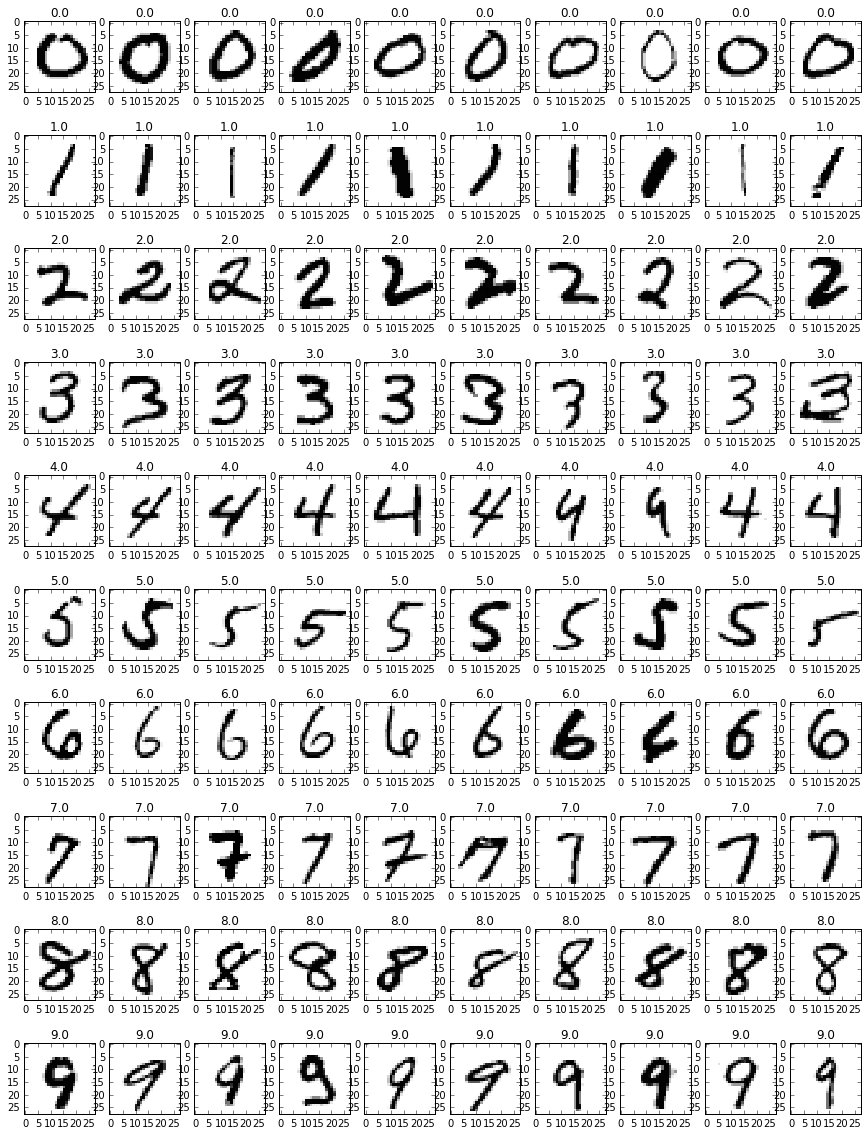

In [480]:
def P1(num_examples=10):

### STUDENT START ###
## I apologize beforehand for my cringeworthy code. This is the most I've done in Python, so I promise it will improve. :)
# Particularly this specific problem caused me to really force things to work the way I pictured
# I had  a bit of trouble logically working between the two arrays and passing the indexes back and forth 
# while also limiting to just 10 of each example, so I created a data frame

    # Create a dataframe of the training data, and add an additional column for the label
    df = pd.DataFrame(train_data)
    df['label']=train_labels
    df_list = []

    # iterate through the data frame 10 times and append 10 examples to a list on each iteration
    for i in range(num_examples):
        temp_df = df.loc[df.label==i]
        df_list.append(temp_df.head(num_examples))
    tens_df = pd.concat(df_list)
    
    # convert the completed list back to a data frame, but omit the "label" column
    data_df = tens_df[range(784)]
    
    # now convert the data frame to a Numpy array
    # yes, this is probably an unecessary amount of conversions
    tens_array = data_df.as_matrix()

    # since objects the new array nwo have a different index from their original array, 
    # we can't match them up with their respective label from train_labels.
    # To address this, I've extracted the original indexes and pull the associated 
    # labels into a new array that lines up with the new array.
    x_labs = np.empty((0,1))
    z_index = data_df.index.values.tolist()
    for j in z_index:
        x_labs = np.append(x_labs, train_labels[j])

    # From this point on, things should be relatively close to what you were hoping to see. 
    # It just took me a bit to get the data to a format that I was comfortable with.
    # These next few lines will reshape each object from a 784 pixel line to a 28x28 pixel block
    # then it will display the pixels in rows with the associated label.
    plt.figure(figsize=(15,20))
    for feature in range(len(tens_array)):
        data_plot = np.array(tens_array[feature], np.float32).reshape(28,28)
        plt.subplot(num_examples,num_examples,feature+1)
        plt.imshow(data_plot,cmap='Greys',interpolation='nearest')
        plt.title(x_labs[feature])
    
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [6]:
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5

In [8]:

import collections 

class OurKNearestNeighbors:
    # Initialize an instance of the class.
    def __init__(self, k, metric=EuclideanDistance):
        self.metric = metric
        self.k = k
    
    # No training for Nearest Neighbors. Just store the data.
    def fit(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return results
    
    # Private function for making a single prediction using KNN.
    def _predict_item(self, item):
        dists = np.array(range(self.k)) + 1000
        dists_labs = np.zeros(self.k) - 10
        max_dist = np.max(dists)
        best_dist, best_label = 1.0e10, None
        
        for i in range(len(self.train_data)):
            dist = self.metric(self.train_data[i], item)
            
            # we assume no ties in the pairwise distances
            if dist < max_dist:
                dists_labs = np.concatenate([np.array([self.train_labels[i]]), dists_labs[dists < max_dist]])
                dists = np.concatenate([np.array([dist]), dists[dists < max_dist]])
                max_dist = np.max(dists)
        
        best_label = collections.Counter(dists_labs).most_common(1)[0][0]
        return best_label

In [479]:
def P2(k_values):
    p2_accuracy=[]
    
### STUDENT START ###
    
    # loop through k values
    for k in k_values:
    
        # using the associated k-value, generate a KNN classifier
        p2_clfk = OurKNearestNeighbors(k=k)
        
        # fit the model using the training data
        p2_clfk.fit(mini_train_data, mini_train_labels)
        
        # Using the model, predict the dev_data's labels
        p2_preds = p2_clfk.predict(dev_data)
        
        # calculate accuracy of predictions and append to list
        p2_accuracy.append(np.mean(p2_preds==dev_labels))
        
        # output variables
        print "k=", k, "; accuracy:", np.mean(p2_preds==dev_labels)
        
        # As requested in the prompt, output a classification report for k=1
        if k ==1:
            print(classification_report(mini_train_labels, p2_preds))

### STUDENT END ###
k_values = [1,3,5,7,9]
P2(k_values)

k= 1 ; accuracy: 0.888
             precision    recall  f1-score   support

        0.0       0.06      0.07      0.06        92
        1.0       0.11      0.12      0.12       106
        2.0       0.09      0.07      0.07       106
        3.0       0.09      0.08      0.09       112
        4.0       0.06      0.07      0.06        91
        5.0       0.10      0.09      0.09        88
        6.0       0.16      0.16      0.16       101
        7.0       0.06      0.07      0.06       101
        8.0       0.04      0.04      0.04        92
        9.0       0.15      0.15      0.15       111

avg / total       0.09      0.09      0.09      1000



## ANSWER:
### From the output in my test, it looks like 8 is the most difficult digit.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [19]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    # loop through training sizes
    for i in train_sizes:
        
        # generate classifier for 1-NN
        clfk = OurKNearestNeighbors(k=1)
        start = time.time()
        
        # using the training size, fit the model with only the specified amount of data
        clfk.fit(train_data[:i], train_labels[:i])
        
        # predict using dev_data, log the end time, and output the required variables
        preds = clfk.predict(dev_data)
        end = time.time()
        accuracies.append(np.mean(preds==dev_labels))
        print "training size:", i, "accuracy:", np.mean(preds==dev_labels), "training time:", (end-start)
        
    return accuracies

### STUDENT END ###

In [468]:
#P3 Run the classification
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
#train_sizes = [10,20,40,80,160,320,640,1280,2500]
accuracies = []
P3(train_sizes, accuracies)

training size: 10 accuracy: 0.318 training time: 6.76600003242
training size: 20 accuracy: 0.396 training time: 13.3320000172
training size: 40 accuracy: 0.545 training time: 27.6730000973
training size: 80 accuracy: 0.672 training time: 57.9040000439
training size: 160 accuracy: 0.759 training time: 106.911000013


[0.318,
 0.39600000000000002,
 0.54500000000000004,
 0.67200000000000004,
 0.75900000000000001]

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

With a coefficient of  [ 0.00277688] , our model would predict an accuracy of  [ 166.61290323]  with a 60000 training size.


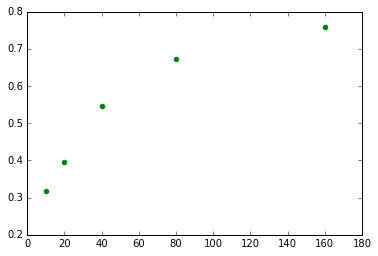

In [477]:
def P4(train_sizes, accuracies):

    ### STUDENT START ###

    # Take the "train_sizes" vector and reshape it to a matrix with single-valued rows
    train_sizes =  np.asarray(train_sizes).reshape((len(train_sizes),1))

    # fit the model using the training sizes and accuracies
    lm = LinearRegression()
    lm.fit(train_sizes, accuracies)
    lm_coef = lm.coef_
    print "With a coefficient of ", lm_coef, ", our model would predict an accuracy of ", lm_coef*60000, " with a 60000 training size."

    # plot the actual data
    plt.scatter(train_sizes,accuracies, color='green')

    ### STUDENT END ###

P4(train_sizes, accuracies)

## ANSWER:
### As seen above, the regression line has a steep incline and then the rate of increase rapidly drops. Due to the fact that our output variable is a probability, we can't use the coefficient as a value for predictions. In the case above, you can see that using a 60,000 training size would cause the model to predict a value greater than 100%, which is impossible. To adjust for this, we could use a logit transformation.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [22]:
def P5():

### STUDENT START ###
    
    p5_clfk = OurKNearestNeighbors(k=1)
    p5_clfk.fit(mini_train_data, mini_train_labels)
    p5_preds = p5_clfk.predict(dev_data)
    return confusion_matrix(dev_labels, p5_preds)
  
### STUDENT END ###

P5()

array([[ 88,   0,   1,   0,   0,   1,   1,   0,   0,   0],
       [  0, 131,   1,   1,   0,   0,   0,   0,   0,   0],
       [  1,   2, 101,   2,   0,   1,   0,   2,   2,   0],
       [  1,   1,   1,  88,   0,   3,   1,   0,   2,   1],
       [  0,   1,   0,   0,  93,   0,   0,   1,   0,  12],
       [  2,   2,   1,   7,   0,  59,   1,   0,   1,   5],
       [  2,   2,   0,   0,   1,   1,  94,   0,   1,   0],
       [  1,   2,   0,   0,   1,   0,   0,  90,   0,   4],
       [  0,   4,   1,   3,   2,   5,   3,   0,  77,   2],
       [  0,   1,   1,   2,   4,   1,   0,   6,   0,  71]])

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [447]:
def P6():
    
### STUDENT START ###

# I struggled with this problem for a *very* long time. I feel like I have a good idea in my head about what to do,
# but I can't get it to happen in python. 

# My thought is to loop through each pixel within each image and identify the surrounding 8 pixels.
# Then apply the gaussian function "x*np.exp(-((x-mu)/sigma)**2)" to calculate the weights of all the surrounding pixels
# and use those weights to adjust the value of the central pixel. 
# Once this weighting & adjusting has been done to each pixel within each image, the image should be blurred/smoothed

# I had trouble with looping through and obtaining the surrounding 8 pixels. I tried 1000 different things and 
# landed on just simply using the built-in gaussian_filter. I wish I'd been able to code up the actual sequence, but couldn't 
# get it working...

    from scipy.ndimage import gaussian_filter

    smooth_train = []
    smooth_dev = []

    # use gaussian filter to smooth training data
    for i in range(len(mini_train_data)):
        smooth_train.append(gaussian_filter(mini_train_data[i], sigma=np.std(mini_train_data[i])))
    
    # use gaussian filter to smooth development data
    for i in range(len(dev_data)):
        smooth_dev.append(gaussian_filter(dev_data[i], sigma=np.std(dev_data[i])))
    
    # generate classifier for 1-NN
    p6_clf = OurKNearestNeighbors(k=1)

    # fit the model using the smoothed training data 
    # and test accuracy with raw development data
    p6_clf.fit(smooth_train, mini_train_labels)
    p6_smooth_train_preds = p6_clf.predict(dev_data)

    # fit the model using raw training data
    # and test the accuracy with smoothed development data
    p6_clf.fit(mini_train_data, mini_train_labels)
    p6_smooth_dev_preds = p6_clf.predict(smooth_dev)

    # fit the model using smoothed training data
    # and test the accuracy with smoothed training data
    p6_clf.fit(smooth_train, mini_train_labels)
    p6_smooth_both_preds = p6_clf.predict(smooth_dev)

    print "Accuracy when only training data are smoothed: ", np.mean(p6_smooth_train_preds==dev_labels)
    print "Accuracy when only development data are smoothed: ", np.mean(p6_smooth_dev_pred==dev_labels)
    print "Accuracy when both training and development data are smoothed: ", np.mean(p6_smooth_both_preds==dev_labels)


### STUDENT END ###

P6()



0.887


## ANSWER:
### See above for output

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [274]:
def multi_thresh(data, splits):
    multi_data = deepcopy(data)
    multi_data[multi_data==1.0] = 2
    for x in range(splits):
        multi_data[np.logical_and(multi_data>=(x/float(splits)), multi_data<((x+1)/float(splits)))] = x
    return multi_data

In [275]:
def P7():

### STUDENT START ###

    # binarize train and dev data according to a 0.5 threshold
    # this will represent a pixel as either black or white

    p7_binarized_train = binarize(train_data, threshold=0.5)
    p7_binarized_dev = binarize(dev_data, threshold=0.5)
    #p7_alpha = 0.0001

    # fit classification model using train data
    p7_clf = BernoulliNB()
    p7_clf.fit(p7_binarized_train, train_labels)

    print "Binarized Bernoulli Accuracy: ", p7_clf.score(p7_binarized_dev, dev_labels)

    # use custom function to split data evenly
    # White: 0-0.33 = 0
    # Grey: 0.33-0.67 = 1
    # Black: 0.67-1 = 2
    multi_train = multi_thresh(train_data, 3)
    multi_dev = multi_thresh(dev_data, 3)

    # fit the newly mapped data with MultinomialNB
    p7_multi_clf = MultinomialNB()
    p7_multi_clf.fit(multi_train, train_labels)
    p7_multi_preds = p7_multi_clf.predict(multi_dev)

    print "Multinomial Accuracy:", p7_multi_clf.score(multi_dev, dev_labels), 

### STUDENT END ###

P7()

Binarized Bernoulli Accuracy:  0.83
Multinomial Accuracy: 0.812


## ANSWER: 
### In our test, Multinomial performed slightly worse than Bernoulli. The usage of Multinomial NB is typically for counting how many occurrences there are of an event. Bernoulli, on the other hand, is very similar, but it simply counts whether an event occurred or not. In our dataset, we see that the accuracy between these two models is expectedly very similar because they are both counting if a pixel contains writing in it. The  slight decrease in performance by Multinomial can be attributed to the fact that we have increased the number of possible values that a pixel can hold, and we're now including more of the "white" space that is left out in the Bernoulli model.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [276]:
def P8(alphas):

### STUDENT START ###
    # I chose to re-binarize the data separately in each necessary problem
    # because I jumped around a lot in the problem set and could never be 100% sure
    # that I never accidentally changed the binarized data
    p8_binarized_train = binarize(train_data, threshold=0.5)

    # Perform the gridsearch according to the given alpha values
    # and fit the model to the binarized data
    p8_clf = GridSearchCV(BernoulliNB(), alphas)
    p8_clf.fit(p8_binarized_train, train_labels)
    
    # output appropriate variables
    print "best estimator:", p8_clf.best_estimator_
    print "best score is:", p8_clf.best_score_
    print "best parameter is:", p8_clf.best_params_
    print "The accuracy when alpha=0 is:", p8_clf.grid_scores_[0][1]
    
### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
P8(alphas)

best estimator: BernoulliNB(alpha=0.0001, binarize=0.0, class_prior=None, fit_prior=True)
best score is: 0.837433333333
best parameter is: {'alpha': 0.0001}
The accuracy when alpha=0 is: 0.09885


## ANSWER: (see above for function output)
### Above I have run BernoulliNB() 9 times via GridSearchCV() with various values of alpha. The alpha value for BernoulliNB() is the smoothing parameter that is used to eliminate occurrences where a given feature never occurs. This typically allows for a more accurate measurement by ensuring each event is at least represented once. In my function above, it's very interesting that there's such a drastic difference between alpha=0 and alpha=0.0001. I did not expect this large of a variation. After alpha=0.0001, the model accuracy decreases at a very slow rate.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [280]:
def P9():

    ### STUDENT END ###
    
    # create and fit the Gaussian model
    p9_clf = GaussianNB()
    p9_clf.fit(mini_train_data, mini_train_labels)
    
    # Re-assign the sigma values to the overall variance of the data.
    # Details in answer below.
    p9_clf.sigma_ = np.full(p9_clf.sigma_.shape, np.var(mini_train_data))
    preds = p9_clf.predict(dev_data)

    print "GaussianNB Accuracy: ", np.mean(preds==dev_labels)
    return p9_clf
    ### STUDENT END ###

gnb = P9()

GaussianNB Accuracy:  0.799


## ANSWER:
### In P9, the GaussianNB function outputs a sigma value that is absurdly low. The reason for this is because there is such a drastic difference between a white pixel and a black pixel, and the vast majority of our pixels are white. This causes our variance (sigma) to misrepresent the pixels that we are actually concerned with. In our case, we are really interested in the colored pixels. By adjusting the sigma value, our accuracy leaps up to ~0.8 (depending on the data randomization). The GaussianNB function sets sigma equal to the variance of each feature. I've reset sigma to be the overall variance across all examples.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

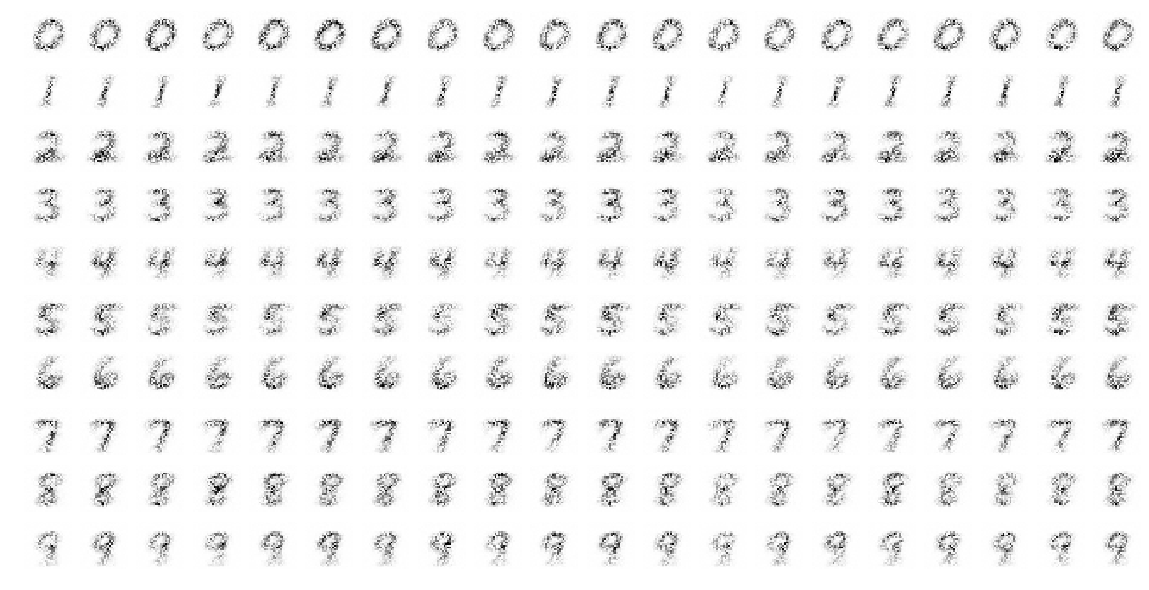

In [281]:
def P10(num_examples):

### STUDENT START ###

    #create a new set of binarized data
    p10_binarized_train = binarize(mini_train_data, threshold=0.5)

    p10_clf = BernoulliNB()
    p10_clf.fit(p10_binarized_train, mini_train_labels)

    # obtain the probabilities for each pixel
    p10_probs = np.exp(p10_clf.feature_log_prob_)

    # generate random numbers
    rand = np.random.rand(num_examples,784)
    generated_nums = []

    # for each number (0-9), multiply the pixel probabilities by the randomized numbers 
    for i in range(len(p10_probs)):
        for j in range(len(rand)):
            y = rand[j] * p10_probs[i]
            generated_nums.append(y)

    #plot all of the generated numbers
    plt.figure(figsize=(num_examples,10))
    for feature in range(len(generated_nums)):
        p10_data_plot = np.array(generated_nums[feature], np.float32).reshape(28,28)
        plt.subplot(10,num_examples,feature+1)
        plt.axis('off')
        plt.imshow(p10_data_plot,cmap='Greys',interpolation='nearest')
    
    
### STUDENT END ###

P10(20)

## ANSWER:
### To be completely honest, I'm already pretty amazed at the simple ability to do that! In the problem above, I've generated a random set of numbers and then multiplied them by the probabilities that were output by the classifier. The resulting arrays were then plotted as seen above. These new numbers are obviously not nearly as clear as the numbers used to train the classifier, but they are nearly all still very legible. As an extra credit problem, it would be interesting to see how we could use this generated output to train a new classifier, and see it's accuracy.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [282]:
def P11(buckets, correct, total):
    
### STUDENT START ###

    # binarize the data and perform the Bernoulli classification
    p11_binarized_train = binarize(train_data, threshold=0.5)
    p11_binarized_dev = binarize(dev_data, threshold=0.5)

    p11_clf = BernoulliNB(alpha=0.0001)
    p11_clf.fit(p11_binarized_train, train_labels)
    p11_preds = p11_clf.predict(p11_binarized_dev)
    p11_probs = p11_clf.predict_proba(p11_binarized_dev)


    # loop through the buckets & compare them to the posterior thresholds
    # if the maximum posterior used to classify the observation is less than the bucket value
    # then we increment the "total" value. 
    # if the classification is actually accurate, then we incrememnt the "correct" value.
    for i in range(len(buckets)):
        for j in range(len(p11_probs)):
            if max(p11_probs[j]) <= buckets[i]:
                total[i] += 1
                if p11_preds[j] == dev_labels[j]:
                    correct[i] += 1
                        
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = float(correct[i]) / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  53    accuracy = 0.472
p(pred) <= 0.9990000000000    total = 138    accuracy = 0.514
p(pred) <= 0.9999900000000    total = 218    accuracy = 0.532
p(pred) <= 0.9999999000000    total = 297    accuracy = 0.586
p(pred) <= 0.9999999990000    total = 377    accuracy = 0.645
p(pred) <= 0.9999999999900    total = 445    accuracy = 0.676
p(pred) <= 0.9999999999999    total = 506    accuracy = 0.700
p(pred) <= 1.0000000000000    total = 1000    accuracy = 0.832


## ANSWER:
### From the output above, I'd say that the model is not incredibly calibrated. There is a large gap between the posterior probabilities and the accuracy of predictions. For instance, with posterior probability of 0.9, the model's accuracy is only at 0.472 (subject to change based on randomization).

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()